In [1]:
%load_ext lab_black

In [2]:
# modules
import numpy as np
import pandas as pd
import seaborn as sns
import pycountry_convert as pc
import matplotlib.pyplot as plt

import sqlite3
import re
import spacy

from functools import reduce
from wordcloud import WordCloud

# EDA part III - Analysis
In fallowing section we will answer some buissness-related question about data.

In [3]:
# params
datapath = "./../data/data_enriched.pkl"

In [4]:
df = pd.read_pickle(datapath)
df.head()

,InvoiceCode,InvoiceNumber,StockNumber,StockCode,StockMark,Description,Quantity,FullPrice,InvoiceDate,UnitPrice,CustomerID,Country,Continent
0,None,536365,85123,A,None,WHITE HANGING HEART T-LIGHT HOLDER,6,15.30,2010-12-01 08:26:00,2.55,17850,United Kingdom,EU
1,None,536365,71053,None,None,WHITE METAL LANTERN,6,20.34,2010-12-01 08:26:00,3.39,17850,United Kingdom,EU
2,None,536365,84406,B,None,CREAM CUPID HEARTS COAT HANGER,8,22.00,2010-12-01 08:26:00,2.75,17850,United Kingdom,EU
3,None,536365,84029,G,None,KNITTED UNION FLAG HOT WATER BOTTLE,6,20.34,2010-12-01 08:26:00,3.39,17850,United Kingdom,EU
4,None,536365,84029,E,None,RED WOOLLY HOTTIE WHITE HEART,6,20.34,2010-12-01 08:26:00,3.39,17850,United Kingdom,EU


### 1. Does every negative `Quantity` record have pasitive counterpart in the past?

In [5]:
df_negative = df[df.Quantity < 0]
df_postive = df[df.Quantity > 0]

In [6]:
conn = sqlite3.connect(":memory:")
df_negative.to_sql("df_neg", conn)
df_postive.to_sql("df_pos", conn)
query = """
    SELECT
        A.*
    FROM 
        df_neg A
    LEFT JOIN 
        df_pos B
    ON
        - A.Quantity = B.Quantity
        AND A.Description = B.Description
        AND A.CustomerID = B.CustomerID
        AND A.InvoiceDate >= B.InvoiceDate
    WHERE 
        B.Quantity IS NULL
"""

res_without_counterpart = pd.read_sql_query(query, conn)

query = """
    SELECT
        A.*
    FROM 
        df_neg A
    LEFT JOIN 
        df_pos B
    ON
        - A.Quantity = B.Quantity
        AND A.Description = B.Description
        AND A.CustomerID = B.CustomerID
        AND A.InvoiceDate >= B.InvoiceDate
    WHERE 
        B.Quantity IS NOT NULL
    ORDER BY
        A.FullPrice
"""

res_with_counterpart = pd.read_sql_query(query, conn)

conn.close()

In [7]:
np.unique(res_without_counterpart.InvoiceCode.fillna("-"))

array(['-', 'C'], dtype=object)

In [8]:
res_without_counterpart.head(3)

,index,InvoiceCode,InvoiceNumber,StockNumber,StockCode,StockMark,Description,Quantity,FullPrice,InvoiceDate,UnitPrice,CustomerID,Country,Continent
0,141,C,536379,None,None,D,DISCOUNT,-1,-27.50,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,EU
1,154,C,536383,35004,C,None,SET OF 3 COLOURED FLYING DUCKS,-1,-4.65,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,EU
2,235,C,536391,22556,None,None,PLASTERS IN TIN CIRCUS PARADE,-12,-19.80,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,EU


In [9]:
res_without_counterpart[res_without_counterpart.InvoiceCode != "C"].head(3)

,index,InvoiceCode,InvoiceNumber,StockNumber,StockCode,StockMark,Description,Quantity,FullPrice,InvoiceDate,UnitPrice,CustomerID,Country,Continent
83,7313,None,537032,21275,None,None,?,-30,NaN,2010-12-03 16:50:00,NaN,NaN,United Kingdom,EU
133,13217,None,537425,84968,F,None,CHECK,-20,NaN,2010-12-06 15:35:00,NaN,NaN,United Kingdom,EU
134,13218,None,537426,84968,E,None,CHECK,-35,NaN,2010-12-06 15:36:00,NaN,NaN,United Kingdom,EU


In [10]:
np.unique(res_with_counterpart.InvoiceCode)

array(['C'], dtype=object)

In [11]:
res_with_counterpart.head(3)

,index,InvoiceCode,InvoiceNumber,StockNumber,StockCode,StockMark,Description,Quantity,FullPrice,InvoiceDate,UnitPrice,CustomerID,Country,Continent
0,540422,C,581484,23843,None,None,"PAPER CRAFT , LITTLE BIRDIE",-80995,-168469.6,2011-12-09 09:27:00,2.08,16446,United Kingdom,EU
1,61624,C,541433,23166,None,None,MEDIUM CERAMIC TOP STORAGE JAR,-74215,-77183.6,2011-01-18 10:17:00,1.04,12346,United Kingdom,EU
2,160145,C,550456,21108,None,None,FAIRY CAKE FLANNEL ASSORTED COLOUR,-3114,-6539.4,2011-04-18 13:08:00,2.10,15749,United Kingdom,EU


#### Answer
As we can see, not all records with negative `Quantity` has positive counterparts in the past; however, it may be caused by the fact that such a transactions was made before data was started collecting. We can also learn that records with negative `Quantity` and `None` in `InvoiceCode` are somehow related to administrative costs and do not represent real transactions; in further analysis we will get rid of them.

In [12]:
df = df[df.Quantity != 0 | (~df.InvoiceCode.isna())]

### 2. What is the time of the day, where most transactions were made?

In [13]:
df_time_day = (
    df.InvoiceDate.dt.hour.value_counts()
    .sort_index()
    .reset_index()
    .rename(columns={"index": "hour", "InvoiceDate": "occurences"})
)

[Text(0.5, 1.0, 'Total number of transactions per hour'),
 Text(0.5, 0, 'Hour of day'),
 Text(0, 0.5, 'number of transactions')]

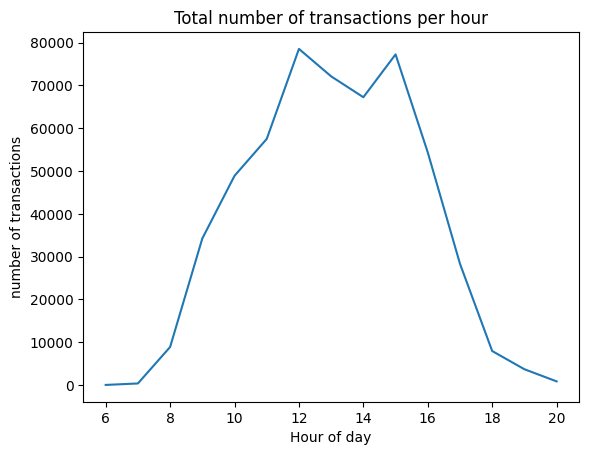

In [14]:
sns.lineplot(data=df_time_day, x="hour", y="occurences").set(
    title="Total number of transactions per hour",
    xlabel="Hour of day",
    ylabel="number of transactions",
)

#### Answer
Time of the biggest traffic is around **12p.m.** and **3p.m.**. What is suprising, there is only records for time from 6a.m. to 8p.m. It may indicate that `InvoiceDate` is not the timestamp of the actually making transaction (e.g. sending money) but acceptance of the transaction by employee.

In [15]:
df_time_weekday = (
    df.InvoiceDate.dt.weekday.value_counts()
    .sort_index()
    .reset_index()
    .rename(columns={"index": "weekday", "InvoiceDate": "transaction_no"})
)
df_time_weekday.weekday = pd.Series(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)

[Text(0.5, 0, 'Weekdays'),
 Text(0, 0.5, 'number of transactions'),
 Text(0.5, 1.0, 'Number of transactions per weekday')]

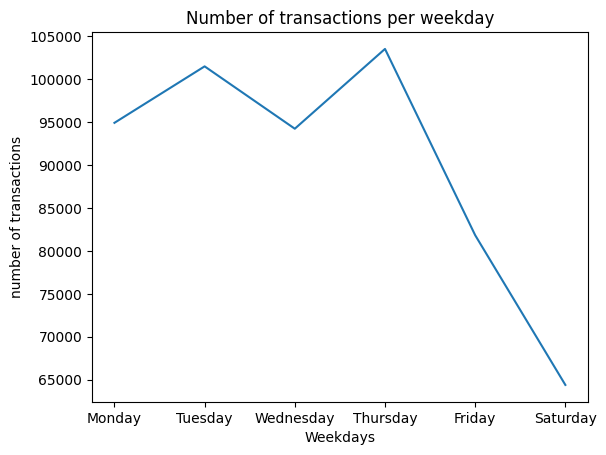

In [16]:
sns.lineplot(data=df_time_weekday, x="weekday", y="transaction_no").set(
    xlabel="Weekdays",
    ylabel="number of transactions",
    title="Number of transactions per weekday",
)

As before, we can see that there is no transaction for **Sunday** because this day is free of work.

### 3. More time series analysis 

In [17]:
%%capture
df_time = df[df.InvoiceDate >= "2011-01-01"]
df_time["week"] = df_time.InvoiceDate.dt.week

In [18]:
%%capture
earn_per_week = df_time.groupby('week').sum()

[Text(0.5, 0, 'week of 2011'),
 Text(0, 0.5, 'total money earned'),
 Text(0.5, 1.0, 'Money earned per week')]

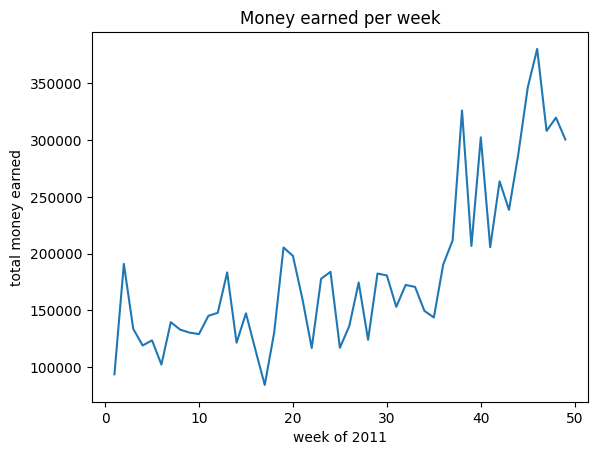

In [19]:
sns.lineplot(data=earn_per_week, x="week", y="FullPrice").set(
    xlabel="week of 2011", ylabel="total money earned", title="Money earned per week"
)

In [20]:
%%capture
earn_per_week_c = df_time[~ df_time.Continent.isna()].groupby(['week', 'Continent']).sum().reset_index()

[Text(0, 0.5, 'Money earned'),
 Text(0.5, 0, 'week of 2021'),
 Text(0.5, 1.0, 'Money earned per continent in time')]

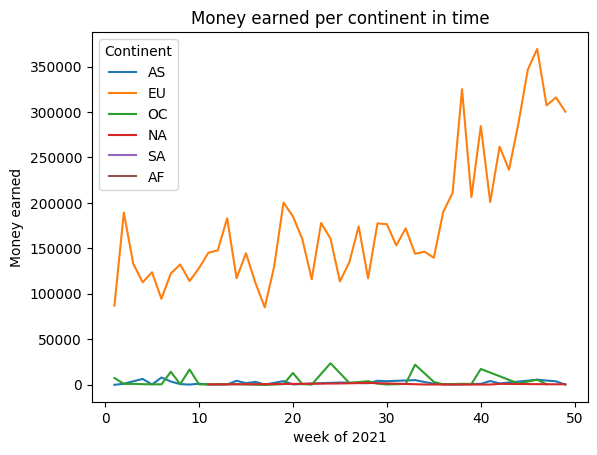

In [21]:
sns.lineplot(data=earn_per_week_c, x="week", y="FullPrice", hue="Continent").set(
    ylabel="Money earned",
    xlabel="week of 2021",
    title="Money earned per continent in time",
)

In [22]:
%%capture
ppl_per_week = df_time.groupby(['week']).nunique()

[Text(0.5, 0, 'week of 2011'),
 Text(0, 0.5, 'Number of customers'),
 Text(0.5, 1.0, 'Number of (unique) customers per week')]

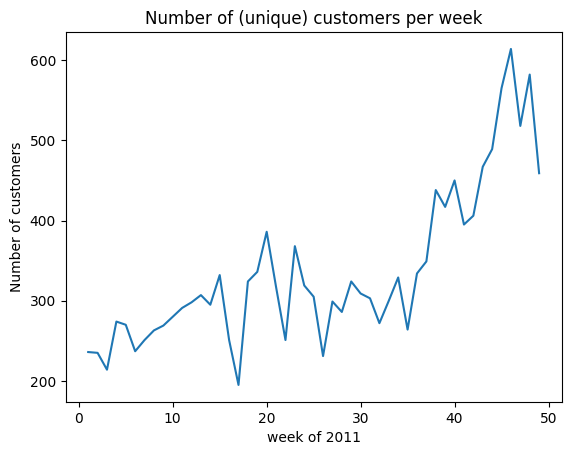

In [23]:
sns.lineplot(data=ppl_per_week, x="week", y="CustomerID").set(
    xlabel="week of 2011",
    ylabel="Number of customers",
    title="Number of (unique) customers per week",
)

In [24]:
%%capture
earn_per_week_c = df_time.copy()
earn_per_week_c['Country'] = earn_per_week_c['Country'].mask(earn_per_week_c['Country'] != 'United Kingdom', 'Other')

earn_per_week_c = earn_per_week_c.groupby(['week', 'Country']).sum().reset_index()

[Text(0.5, 0, 'week of 2011'),
 Text(0, 0.5, 'money earned'),
 Text(0.5, 1.0, 'United Kingdom versus other country comparison')]

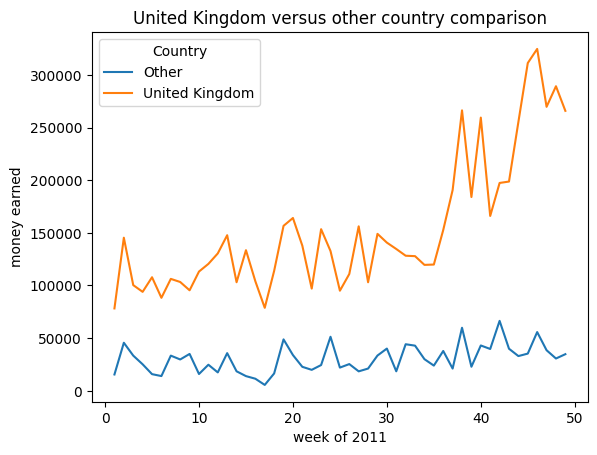

In [25]:
sns.lineplot(data=earn_per_week_c, x="week", y="FullPrice", hue="Country").set(
    xlabel="week of 2011",
    ylabel="money earned",
    title="United Kingdom versus other country comparison",
)

### 4. What is the meaning of unusual `PostingCode`?

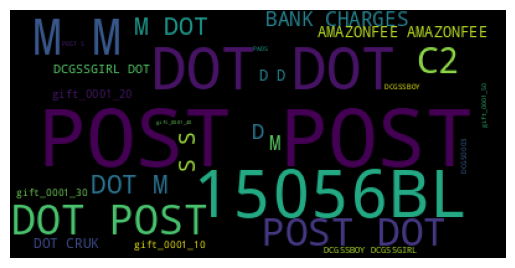

In [26]:
unusual_words = df.StockMark[np.negative(df.StockMark.isna())].str.cat(sep=" ")
wc = WordCloud(background_color="black", repeat=False)
wc.generate(unusual_words)

plt.imshow(wc)
plt.axis("off")
plt.show()

In [27]:
df[np.negative(df.StockMark.isna())].groupby(
    ["StockMark", "Description"]
).size().sort_values(ascending=False)[:15]

StockMark     Description                      
POST          POSTAGE                              1252
DOT           DOTCOM POSTAGE                        709
M             MANUAL                                571
15056BL       EDWARDIAN PARASOL BLACK               326
C2            CARRIAGE                              143
D             DISCOUNT                               77
S             SAMPLES                                63
15056bl       EDWARDIAN PARASOL BLACK                62
BANK CHARGES  BANK CHARGES                           37
AMAZONFEE     AMAZON FEE                             34
CRUK          CRUK COMMISSION                        16
DCGSSGIRL     GIRLS PARTY BAG                        13
DCGSSBOY      BOYS PARTY BAG                         11
gift_0001_20  DOTCOMGIFTSHOP GIFT VOUCHER £2000       9
gift_0001_10  DOTCOMGIFTSHOP GIFT VOUCHER £1000       8
dtype: int64

#### Answer
As we can see, most *unusual* codes have special meaning, like `DISCOUNT` but there are also some codes that describe special and no so special products. The further we dig in data, the more messy it seems to be. 

In [28]:
df = df[df.StockMark.isna()]

### 5. what are the most expensive products ever sold?

[Text(0, 0, '649.5'),
 Text(0, 0, '295'),
 Text(0, 0, '295'),
 Text(0, 0, '195'),
 Text(0, 0, '165'),
 Text(0, 0, '165'),
 Text(0, 0, '125'),
 Text(0, 0, '100'),
 Text(0, 0, '99.96'),
 Text(0, 0, '99.96')]

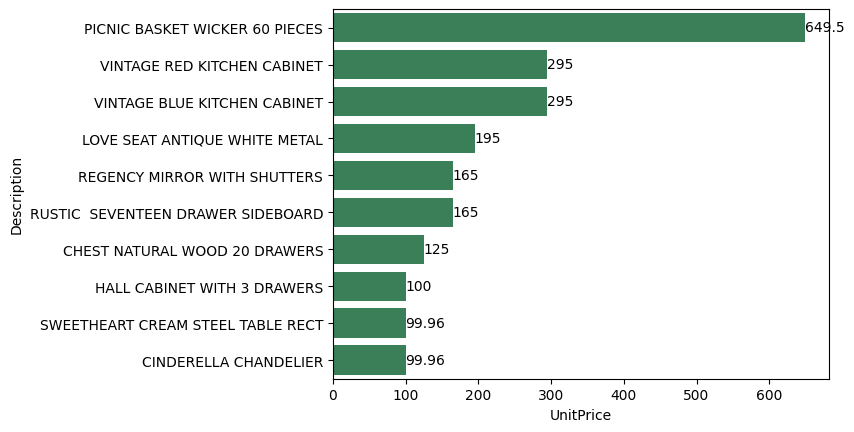

In [29]:
most_expensive_products = (
    df[df.StockMark.isna()]
    .groupby(["Description"])
    .max("UnitPrice")
    .sort_values(by="UnitPrice", ascending=False)[:10]
)

ax = sns.barplot(
    data=most_expensive_products.reset_index(),
    x="UnitPrice",
    y="Description",
    color="seagreen",
)
ax.bar_label(ax.containers[0])

#### Answer
The most expensive is **picnic basket** and costs 649.5£. However, most products are much cheaper.


### 6. What is the most expensive single transaction?

In [30]:
%%capture
most_expensive_transactions = (
    df[df.Quantity > 0]
    .fillna(-1)
    .groupby(["InvoiceCode", "InvoiceNumber"])
    .sum()
    .sort_values(["FullPrice"], ascending=False)
    .reset_index()
)

In [31]:
m_code, m_number = (
    most_expensive_transactions.iloc[0, 0],
    most_expensive_transactions.iloc[0, 1],
)
df[(df.InvoiceCode.fillna(-1) == m_code) & (df.InvoiceNumber == m_number)]

,InvoiceCode,InvoiceNumber,StockNumber,StockCode,StockMark,Description,Quantity,FullPrice,InvoiceDate,UnitPrice,CustomerID,Country,Continent
540421,None,581483,23843,None,None,"PAPER CRAFT , LITTLE BIRDIE",80995,168469.6,2011-12-09 09:15:00,2.08,16446,United Kingdom,EU


#### Answer
The most expensive was transaction that included only one product - probably the `Qunatity` was mistakenly put down to database, as it was returned almost immediatly.

In [32]:
df[df.Quantity == -80995]

,InvoiceCode,InvoiceNumber,StockNumber,StockCode,StockMark,Description,Quantity,FullPrice,InvoiceDate,UnitPrice,CustomerID,Country,Continent
540422,C,581484,23843,None,None,"PAPER CRAFT , LITTLE BIRDIE",-80995,-168469.6,2011-12-09 09:27:00,2.08,16446,United Kingdom,EU


### 7. What is average amount of different products sold in single transation?

In [33]:
print(
    f'Average amount of money spent in single transaction: {df.fillna(-1).groupby(["InvoiceCode", "InvoiceNumber"]).count().mean()[0]:.2f}'
)

Average amount of money spent in single transaction: 22.53
